In [1]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
import keras.layers as layers
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.metrics import confusion_matrix

2024-05-26 03:41:56.387199: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 03:41:56.900869: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DataSolarModules = pd.read_json('InfraredSolarModules/module_metadata.json').transpose().sort_index()
DataSolarModulesGT = pd.read_json('InfraredSolarModules/GT_metadata.json').transpose().sort_index()
DataSolarModulesVAE = pd.read_json('InfraredSolarModules/VAE_metadata.json').transpose().sort_index()
Classes = DataSolarModules['anomaly_class'].unique()
class_to_number = dict(enumerate(Classes.flatten(), 0))
class_to_number = {v: k for k, v in class_to_number.items()}

In [3]:
def map_to_class(value):
    class_to_number
    return class_to_number.get(value, 'Unknown')

DataSolarModules['class_code'] = DataSolarModules['anomaly_class'].apply(map_to_class)
DataSolarModulesGT['class_code'] = DataSolarModulesGT['anomaly_class'].apply(map_to_class)
DataSolarModulesVAE['class_code'] = DataSolarModulesVAE['anomaly_class'].apply(map_to_class)

In [4]:
def read_images_dataframe(dataframe):
    images = []
    for image_path in dataframe['image_filepath']:
        img = cv2.imread("InfraredSolarModules/"+image_path,cv2.IMREAD_GRAYSCALE)
        img = img.reshape(40, 24).astype("float32") / 255
        images.append(img)
    images=np.array(images) 
    return images

def read_labels_dataframe(dataframe):
    labels = []
    for label in dataframe['class_code']:
        labels.append(label)
    labels=np.array(labels) 
    labels.astype("int32")   
    return labels

In [5]:
images_OG = read_images_dataframe(DataSolarModules)
images_GT = read_images_dataframe(DataSolarModulesGT)
images_VAE = read_images_dataframe(DataSolarModulesVAE)
labels_OG = read_labels_dataframe(DataSolarModules)
labels_GT = read_labels_dataframe(DataSolarModulesGT)
labels_VAE = read_labels_dataframe(DataSolarModulesVAE)

images=np.concatenate((images_OG, images_GT, images_VAE), axis=0)
labels=np.concatenate((labels_OG, labels_GT, labels_VAE), axis=0)

In [6]:
# Create a testing set with 25 images per class
num_images_per_class = 40

def create_testing_set(dataframe, num_images_per_class):
    test_indices = []
    for cls in dataframe['class_code'].unique():
        class_indices = dataframe[dataframe['class_code'] == cls].index[:num_images_per_class].tolist()
        test_indices.extend(class_indices)
    return test_indices

test_indices = create_testing_set(DataSolarModules, num_images_per_class)
data_test = np.array(test_indices)

# Create a training set with the remaining images
data_train = np.setdiff1d(np.arange(len(images)), data_test)

In [7]:
inputs = keras.Input(shape=(40, 24, 1))


x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)

x = layers.Dense(2048, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(128, activation="relu")(x)


outputs = layers.Dense(12, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

2024-05-26 03:42:12.516494: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-26 03:42:12.545845: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-26 03:42:12.546073: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40, 24, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 38, 22, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 11, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 9, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,386,956 (16.73 MB)

 Trainable params: 4,386,956 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
batch_size = 64
n_epochs = 25

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

rkf = RepeatedKFold(n_splits=6, n_repeats=3, random_state=21312312)


model.compile(optimizer=optimizer,                                    
              loss="sparse_categorical_crossentropy",                 
              metrics=["accuracy"])   

In [9]:
fold_no = 1
acc_per_fold = []
loss_per_fold = []

all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

for train, val in rkf.split(data_train):

    history_model = model.fit(images[train], labels[train],
                              epochs=n_epochs,
                              validation_data=(images[val], labels[val]),
                              batch_size=batch_size)

    # Store metrics for this fold
    fold_train_loss = np.mean(history_model.history['loss'])
    fold_train_accuracy = np.mean(history_model.history['accuracy'])
    fold_val_loss = np.mean(history_model.history['val_loss'])
    fold_val_accuracy = np.mean(history_model.history['val_accuracy'])

    all_train_losses.append(fold_train_loss)
    all_train_accuracies.append(fold_train_accuracy)
    all_val_losses.append(fold_val_loss)
    all_val_accuracies.append(fold_val_accuracy)

    # Generate generalization metrics for the last epoch
    scores = model.evaluate(images[val], labels[val],verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1

Epoch 1/25


I0000 00:00:1716666134.424794  226661 service.cc:145] XLA service 0x757ed8012ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716666134.424816  226661 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-05-26 03:42:14.460196: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-26 03:42:14.642420: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 109/1409 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4525 - loss: 1.9834

I0000 00:00:1716666138.783468  226661 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1409/1409 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4724 - loss: 1.8148

I0000 00:00:1716666158.332877  226881 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716666158.616664  226869 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716666158.706339  226875 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 308 bytes spill stores, 308 bytes spill loads

I0000 00:00:1716666160.464613  226994 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1716666160.814155  226998 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 308 bytes spill stores, 308 bytes spill loads

I0000 00:00:1716666160.926484 

1409/1409 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.4724 - loss: 1.8147 - val_accuracy: 0.5813 - val_loss: 1.3868
Epoch 2/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5952 - loss: 1.3274 - val_accuracy: 0.6406 - val_loss: 1.1487
Epoch 3/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6403 - loss: 1.1547 - val_accuracy: 0.6741 - val_loss: 1.0319
Epoch 4/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6599 - loss: 1.0766 - val_accuracy: 0.6810 - val_loss: 1.0012
Epoch 5/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6781 - loss: 1.0027 - val_accuracy: 0.6942 - val_loss: 0.9309
Epoch 6/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6921 - loss: 0.9469 - val_accuracy: 0.7034 - val_loss: 0.9077
Epoch 7/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7046 - loss: 0.9048 - val_accuracy: 0.7222 - val_loss: 0.8438
Epoch 8/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7153 - loss: 0.8774 - val_accur

I0000 00:00:1716666210.308249  228487 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716666210.423638  228478 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716666210.435229  228481 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1716666211.672789  228610 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_103', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1716666212.029128  228597 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 8 bytes spill stores, 16 bytes spill loads



Score for fold 1: loss of 0.6188741326332092; compile_metrics of 79.58062887191772%
Epoch 1/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7879 - loss: 0.6396 - val_accuracy: 0.8377 - val_loss: 0.4905
Epoch 2/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7960 - loss: 0.6150 - val_accuracy: 0.8411 - val_loss: 0.4849
Epoch 3/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7980 - loss: 0.6062 - val_accuracy: 0.8389 - val_loss: 0.4903
Epoch 4/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8003 - loss: 0.6033 - val_accuracy: 0.8303 - val_loss: 0.5208
Epoch 5/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8078 - loss: 0.5798 - val_accuracy: 0.8420 - val_loss: 0.4779
Epoch 6/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8088 - loss: 0.5774 - val_accuracy: 0.8365 - val_loss: 0.4933
Epoch 7/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8104 - loss: 0.5706 - val_accuracy: 0.8320 - val_loss: 0.5205
Epoch 

I0000 00:00:1716666436.355662  234566 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 264 bytes spill stores, 264 bytes spill loads

I0000 00:00:1716666436.368374  234552 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1716666436.853665  234553 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 308 bytes spill stores, 308 bytes spill loads



1409/1409 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.8960 - loss: 0.3376 - val_accuracy: 0.9626 - val_loss: 0.1471
Epoch 2/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8992 - loss: 0.3237 - val_accuracy: 0.9642 - val_loss: 0.1295
Epoch 3/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9062 - loss: 0.3018 - val_accuracy: 0.9623 - val_loss: 0.1336
Epoch 4/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9043 - loss: 0.3086 - val_accuracy: 0.9591 - val_loss: 0.1382
Epoch 5/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9039 - loss: 0.3066 - val_accuracy: 0.9608 - val_loss: 0.1367
Epoch 6/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9052 - loss: 0.3001 - val_accuracy: 0.9447 - val_loss: 0.1787
Epoch 7/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9039 - loss: 0.3100 - val_accuracy: 0.9566 - val_loss: 0.1457
Epoch 8/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9058 - loss: 0.2964 - val_accur

I0000 00:00:1716666486.820572  236064 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_103', 8 bytes spill stores, 8 bytes spill loads



Score for fold 6: loss of 0.18651962280273438; compile_metrics of 93.88105869293213%
Epoch 1/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9054 - loss: 0.3121 - val_accuracy: 0.9604 - val_loss: 0.1406
Epoch 2/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9102 - loss: 0.2866 - val_accuracy: 0.9674 - val_loss: 0.1208
Epoch 3/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9156 - loss: 0.2768 - val_accuracy: 0.9592 - val_loss: 0.1405
Epoch 4/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9167 - loss: 0.2710 - val_accuracy: 0.9514 - val_loss: 0.1553
Epoch 5/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9163 - loss: 0.2719 - val_accuracy: 0.9599 - val_loss: 0.1368
Epoch 6/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9159 - loss: 0.2700 - val_accuracy: 0.9631 - val_loss: 0.1250
Epoch 7/25
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9174 - loss: 0.2679 - val_accuracy: 0.9583 - val_loss: 0.1384
Epoch

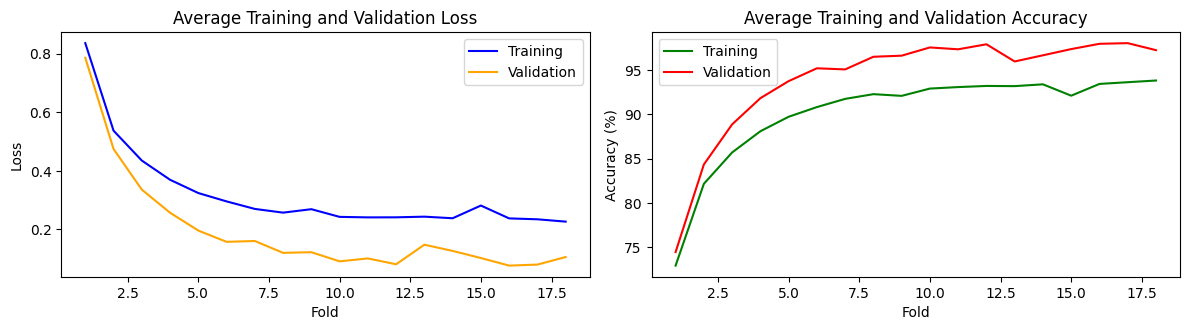

In [10]:
plt.figure(figsize=(12, 6))

# Plotting average training and validation losses
plt.subplot(2, 2, 1)
plt.plot(range(1, len(all_train_losses) + 1), all_train_losses, color='blue', label='Training')
plt.plot(range(1, len(all_val_losses) + 1), all_val_losses, color='orange', label='Validation')
plt.title('Average Training and Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()

# Plotting average training and validation accuracies
plt.subplot(2, 2, 2)
plt.plot(range(1, len(all_train_accuracies) + 1), [acc * 100 for acc in all_train_accuracies], color='green', label='Training')
plt.plot(range(1, len(all_val_accuracies) + 1), [acc * 100 for acc in all_val_accuracies], color='red', label='Validation')
plt.title('Average Training and Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
test_metrics = model.evaluate(images[data_test], labels[data_test])  
print("Test loss:", test_metrics[0])
print("Test accuracy:", test_metrics[1])

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 1.0000 - loss: 0.0036
Test loss: 0.005321092903614044
Test accuracy: 1.0


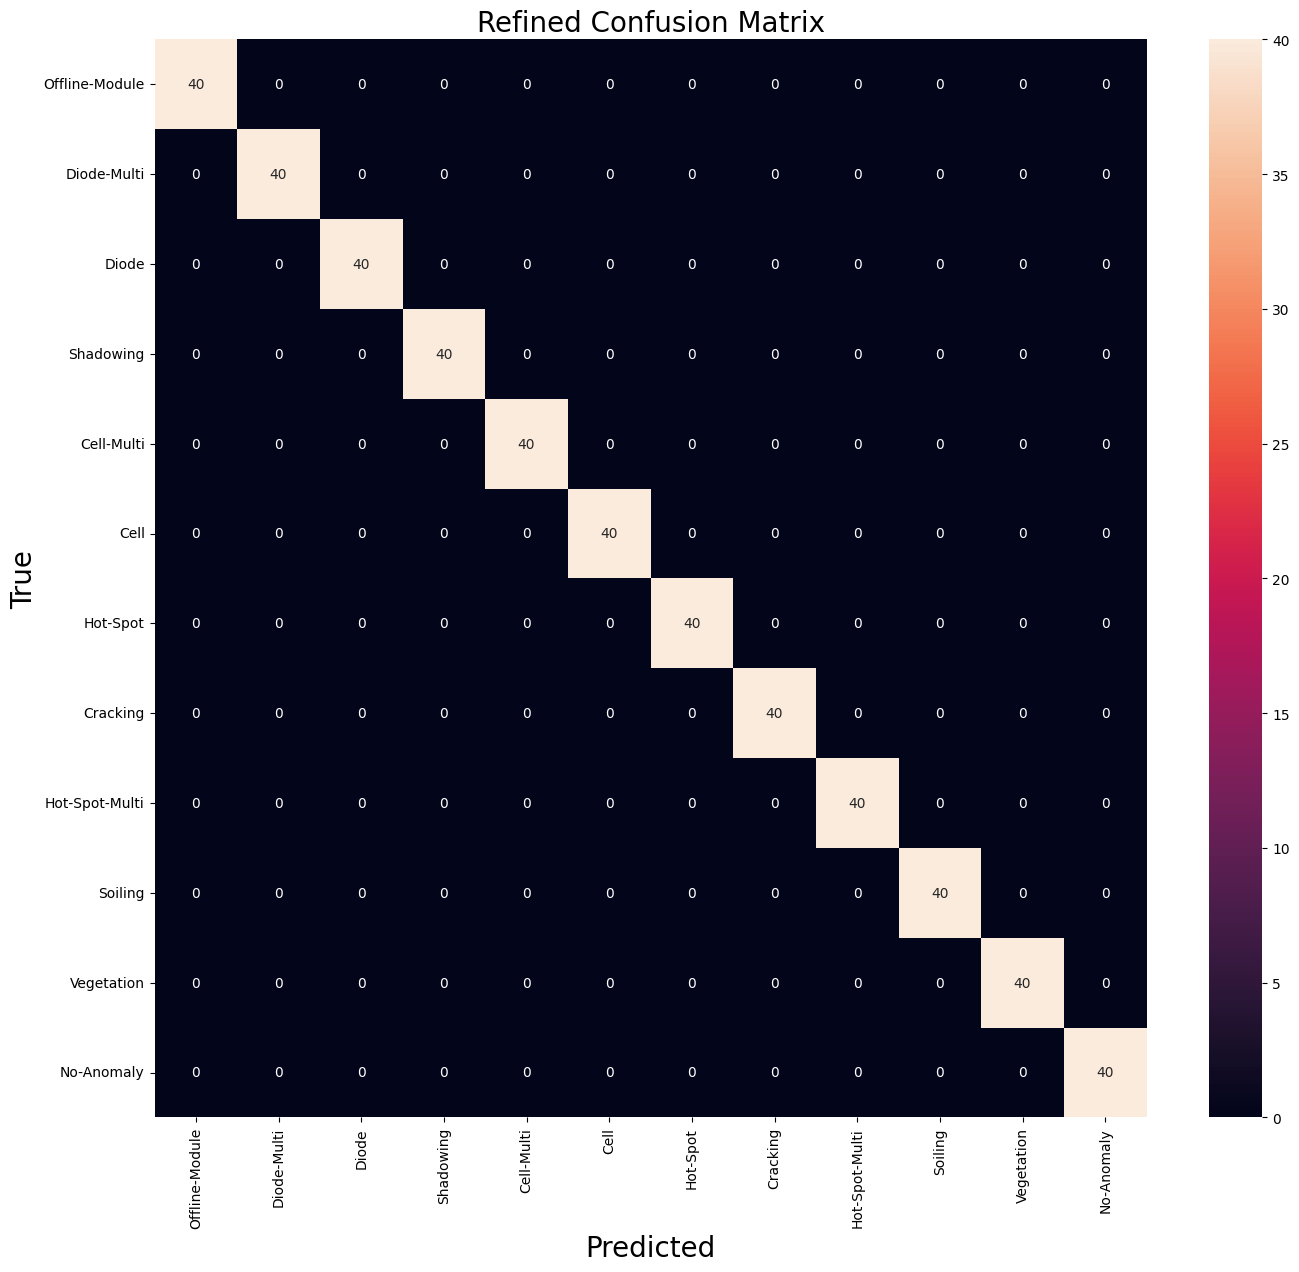

In [12]:
### Confusion Matrix
predictions = model.predict(images[data_test], steps=len(data_test), verbose=0)

y_pred = np.argmax(predictions, axis=-1)

cm = confusion_matrix(labels[data_test], y_pred)

## Get Class Labels
class_names = Classes

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True,robust=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.show()

In [13]:
tp_and_fn = cm.sum(1)
tp_and_fp = cm.sum(0)
tp = cm.diagonal()
accuracy = cm.diagonal().sum()/cm.sum()
precision = tp / tp_and_fp
recall = tp / tp_and_fn
f1 = 2 * (precision * recall) / (precision + recall)
precision_avg=np.average(precision)
recall_avg=np.average(recall)
f1_avg=np.average(f1)

In [14]:
# Creating a dictionary with the data
data = {
    'Metrics': ['Accuracy', 'Average Precision', 'Average Recall', 'Average F1 Score'],
    'Values': [accuracy, precision_avg, recall_avg, f1_avg]
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

             Metrics  Values
0           Accuracy     1.0
1  Average Precision     1.0
2     Average Recall     1.0
3   Average F1 Score     1.0


In [15]:
data = {
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

             Class  Precision  Recall  F1 Score
0   Offline-Module        1.0     1.0       1.0
1      Diode-Multi        1.0     1.0       1.0
2            Diode        1.0     1.0       1.0
3        Shadowing        1.0     1.0       1.0
4       Cell-Multi        1.0     1.0       1.0
5             Cell        1.0     1.0       1.0
6         Hot-Spot        1.0     1.0       1.0
7         Cracking        1.0     1.0       1.0
8   Hot-Spot-Multi        1.0     1.0       1.0
9          Soiling        1.0     1.0       1.0
10      Vegetation        1.0     1.0       1.0
11      No-Anomaly        1.0     1.0       1.0
